## IMPORTS

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
from functions import train_index_updater
from functions import data_constructor
from functions import dataframe_generator
from functions import index_generator
from functions import load_labels

## SETTING UP PARAMETERS AND DIRECTORIES

In [3]:
SEED = 12
IMG_HEIGHT = 128
IMG_WIDTH = 128
DIM = (IMG_HEIGHT, IMG_WIDTH)
TRAIN_SET= 143778
VALID_SET= 25486
EPOCHS = 25
BS = 32
LR = 0.0003
n=50000
label_file_train = "C:\project\data\\train_COVIDx_CT-2A.txt"
label_file_valid = "C:\project\data\\val_COVIDx_CT-2A.txt"

## LOADING DATA

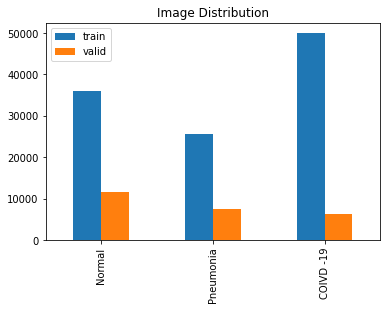

In [4]:
fnames_train , classes_train ,bboxes_train = load_labels(label_file_train)
fnames_valid , classes_valid ,bboxes_valid = load_labels(label_file_valid)
train_index = index_generator(fnames_train , TRAIN_SET)
valid_index = index_generator(fnames_valid , VALID_SET)
train_index_updated = train_index_updater(classes_train,train_index,n )
df = dataframe_generator(train_index_updated, valid_index , classes_train , classes_valid)
df.plot.bar( title = "Image Distribution" );

## Loading Training and Validation Images

In [5]:
x_train, y_train = data_constructor(fnames_train,classes_train, DIM , index  =train_index_updated ,bboxes = bboxes_train )
x_valid , y_valid= data_constructor(fnames_valid,classes_valid, DIM , index  =valid_index , bboxes = bboxes_valid )

## Pre-Processing

In [6]:
x_train = tf.keras.applications.resnet_v2.preprocess_input(x_train)
x_valid = tf.keras.applications.resnet_v2.preprocess_input(x_valid)

In [7]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,zoom_range=0.05,width_shift_range=0.2 ,height_shift_range=0.1,shear_range=0.05)## ENTER YOUR AUG HERE
train_generator = data_generator.flow(x_train, y_train, BS)
spe = x_train.shape[0] // BS

## MODEL DESIGN

In [8]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [9]:
base_model = ResNet152V2(include_top=False,weights="imagenet",input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))
model= tf.keras.Sequential()
model.add(base_model) 
model.add(GlobalAveragePooling2D())
model.add(Dense(3,activation=('softmax')))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 4, 4, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 58,337,795
Trainable params: 58,194,051
Non-trainable params: 143,744
_________________________________________________________________


In [11]:
model.compile(optimizer=tf.keras.optimizers.SGD(LR),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelsdir = "models/ResNet"
checkpoint = ModelCheckpoint(filepath = modelsdir + "/SGD.{epoch:02d}-{val_accuracy:.4f}.h5" ,
                             monitor= "val_accuracy" , 
                             mode = "max",
                            verbose = 0,
                            save_best_only=True)

In [13]:
r = model.fit(train_generator , validation_data=(x_valid, y_valid), steps_per_epoch = spe ,epochs=EPOCHS, callbacks = [checkpoint]  )

  ...
    to  
  ['...']
Train for 3487 steps, validate on 25486 samples
Epoch 1/25
3487/3487 [==============================] - 1502s 431ms/step - loss: 0.4276 - accuracy: 0.8292 - val_loss: 0.3148 - val_accuracy: 0.8944
Epoch 2/25
3487/3487 [==============================] - 1484s 426ms/step - loss: 0.2044 - accuracy: 0.9260 - val_loss: 0.2338 - val_accuracy: 0.9164
Epoch 3/25
3487/3487 [==============================] - 1492s 428ms/step - loss: 0.1568 - accuracy: 0.9441 - val_loss: 0.2106 - val_accuracy: 0.9286
Epoch 4/25
3487/3487 [==============================] - 1495s 429ms/step - loss: 0.1287 - accuracy: 0.9540 - val_loss: 0.1906 - val_accuracy: 0.9353
Epoch 5/25
3487/3487 [==============================] - 1497s 429ms/step - loss: 0.1113 - accuracy: 0.9613 - val_loss: 0.1846 - val_accuracy: 0.9401
Epoch 6/25
3487/3487 [==============================] - 1488s 427ms/step - loss: 0.0964 - accuracy: 0.9663 - val_loss: 0.1777 - val_accuracy: 0.9411
Epoch 7/25
3487/3487 [===========

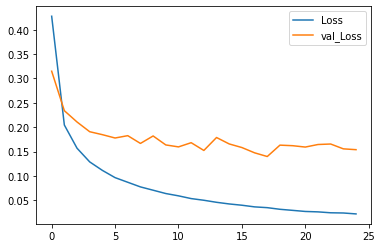

In [14]:
plt.plot(r.history["loss"], label= "Loss")
plt.plot(r.history["val_loss"], label = "val_Loss")
plt.legend();

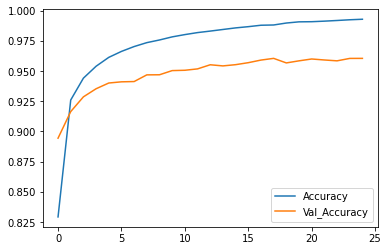

In [15]:
plt.plot(r.history["accuracy"] ,label = "Accuracy")
plt.plot(r.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

In [16]:
pd.DataFrame(r.history).to_csv("csv/ResNet.csv",index=False)

In [17]:
model.save("models/ResNet/ResNet.h5")